We're going to be building a structure inspired by the symmetry of the gyroid shape. Specifically, this will be part of space group 230 and shares symmetry with the achiral 2-srs network reported [here](https://onlinelibrary.wiley.com/doi/10.1002/adom.201800485)


In [32]:
import crystalbuilder.bilbao as cbb

single_gyr = cbb.SpaceGroup(230, points=[(.25, 0,.25)])

The above cell imports the bilbao module and pulls the generators/symmetry operations from the server. With the initial points specified, the single_gyr object now contains all of the points in the unit cell.

We need to build this unit cell using the geometry functions in crystalbuilder's geometry module. This could probably be done with MEEP as well, but it would generally be tedious to transform all of the points into lattice coordinates for MPB. **Note that it would not be as tedious here because the cubic cell lattice vectors are parallel to the cartesian axes.**

In [33]:
import crystalbuilder.geometry as geo

a = .5

rad = .25*a

unit_cell = geo.SuperCell([])

for n in single_gyr.generated_points:
    sphere = geo.Sphere(center=n, radius=rad)
    unit_cell.add_structure(sphere)

# unit_cell.identify_structures()

In [34]:
import crystalbuilder.lattice as lat

lattice = lat.Lattice()

crystal = lattice.tile_geogeometry(unit_cell, 3, 3, 3)


In [35]:
import crystalbuilder.convert as cv
import meep as mp
from meep import mpb

mat1 = mp.Medium(epsilon=10)
mpb_geo = cv.geo_to_mpb(unit_cell, material=mat1, lattice=cv.to_mpb_lattice(lattice))
# geometry_lattice = mp.Lattice()
for n in mpb_geo:
    print(n)

    
geometry_lattice = cv.to_mpb_lattice(lattice)

vlist = [
    mp.Vector3(0, 0.5, 0.5),        # H
    mp.Vector3(.25, .25, .25),       # P
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0, 0.5),        # N

]
k_corners = len(vlist)



k_points = mp.interpolate(1, vlist)
tick_labs = ['H', 'P', 'GM', 'N']
resolution = 32
num_bands = 10

ms = mpb.ModeSolver(
    geometry=mpb_geo,
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
)

ms.run()



Initializing eigensolver data
Computing 10 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 32 x 32 x 32.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     sphere, center = (0.25,0,0.25)
          radius 0.125
     sphere, center = (0.25,0,0.75)
          radius 0.125
     sphere, center = (-0.25,0.5,0.25)
          radius 0.125
     sphere, center = (0.75,0.5,-0.25)
          radius 0.125
     sphere, center = (0.25,0.25,0)
          radius 0.125
     sphere, center = (0.75,0.25,0)
          radius 0.125
     sphere, center = (0.25,-0.25,0.5)
          radius 0.125
     sphere, center = (-0.25,0.75,0.5)
          radius 0.125
     sphere, center = (0,0.25,0.25)
          radius 0.125
     sphere, center = (0,0.75,0.25)
          radius 0.125
     sphere, center 

epsilon: 1-10, mean 4.51877, harm. mean 1.75716, 57.8613% > 1, 39.0975% "fill"
real part range: 1 .. 10


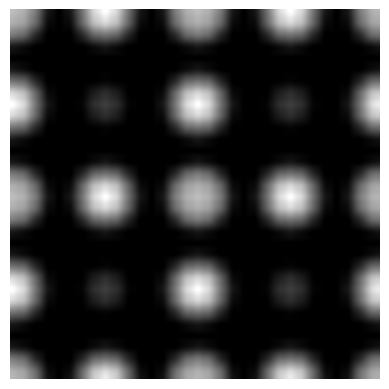

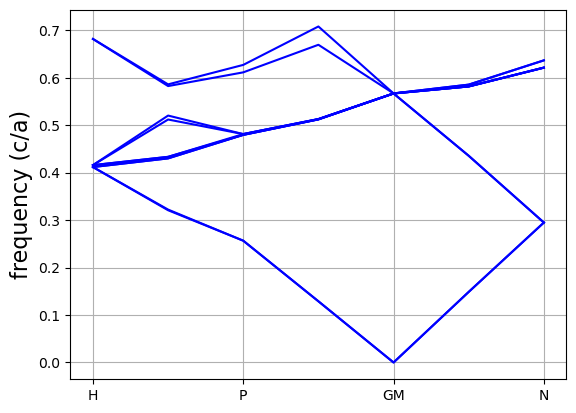

In [36]:
import matplotlib.pyplot as plt
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=True, periods=1, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
layer_slice = 9
plt.imshow(converted_eps[:,:, layer_slice], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue');
points_in_between = (len(crysfreqs)-1) / (k_corners-1)
tick_locs = [i*points_in_between for i in range(k_corners)]

plt.xticks(tick_locs,tick_labs)
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()

plt.show()
